In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

In [4]:
SAVE_DIR = Path().cwd() # mes/paper_plots
DATA_DIR = Path().cwd().parent / "data" # mes/data
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [6]:
# df = pd.read_json(DATA_DIR / "benchmark_df.json")
df = pd.read_json(DATA_DIR / "benchmark_gamma_ablation_Matern52_2.json")

df["regret"] = df.apply(lambda x: x["y_true_max"] - np.array(x["y_max_history"]), axis=1)
df = df.drop(columns=["y_true_max", "final_y_max", "y_max_history"]) # cleanup rows
df = df.explode(["regret", "steps"], ignore_index=True) # explode history into seperate rows
df["regret"] = pd.to_numeric(df["regret"], errors="raise")
df

,acq_func,kernel_type,len_scale,n_dim,run_id,steps,regret
0,ves_exp_2,matern-5/2,8,2,0,4,1.011778
1,ves_exp_2,matern-5/2,8,2,0,5,1.011778
2,ves_exp_2,matern-5/2,8,2,0,6,1.011778
3,ves_exp_2,matern-5/2,8,2,0,7,1.011778
4,ves_exp_2,matern-5/2,8,2,0,8,1.011778
...,...,...,...,...,...,...,...
58195,ves_gamma_0_2,matern-5/2,8,2,99,96,0.000000
58196,ves_gamma_0_2,matern-5/2,8,2,99,97,0.000000
58197,ves_gamma_0_2,matern-5/2,8,2,99,98,0.000000
58198,ves_gamma_0_2,matern-5/2,8,2,99,99,0.000000


In [7]:
regret_df = df.groupby(['kernel_type', 'n_dim', 'acq_func', 'steps'])
regret_df = regret_df['regret'].agg(['mean', 'std', 'count'])
regret_df # multi-index of key: (kernel_type, n_dim, acq_func, steps)

mean       std  count
kernel_type n_dim acq_func      steps                           
matern-5/2  2     ves_exp_0     4      1.523395  0.791916    100
                                5      1.428302  0.755573    100
                                6      1.323904  0.738345    100
                                7      1.228073  0.718833    100
                                8      1.145633  0.683286    100
...                                         ...       ...    ...
                  ves_gamma_0_2 96     0.025741  0.149598    100
                                97     0.025741  0.149598    100
                                98     0.025741  0.149598    100
                                99     0.025741  0.149598    100
                                100    0.025741  0.149598    100

[582 rows x 3 columns]

This gives us a multi-index dataframe with unique keys of `(kernel_type, n_dim, acq_func, steps)` and mean, std, count regret for each row.

To index into a single kernel / dimension, we can use:

In [9]:
regret_df.loc[('matern-5/2', 4)]

KeyError: 4

/Users/tomp/work/mes/paper_plots/benchmark-matern-3_2.png


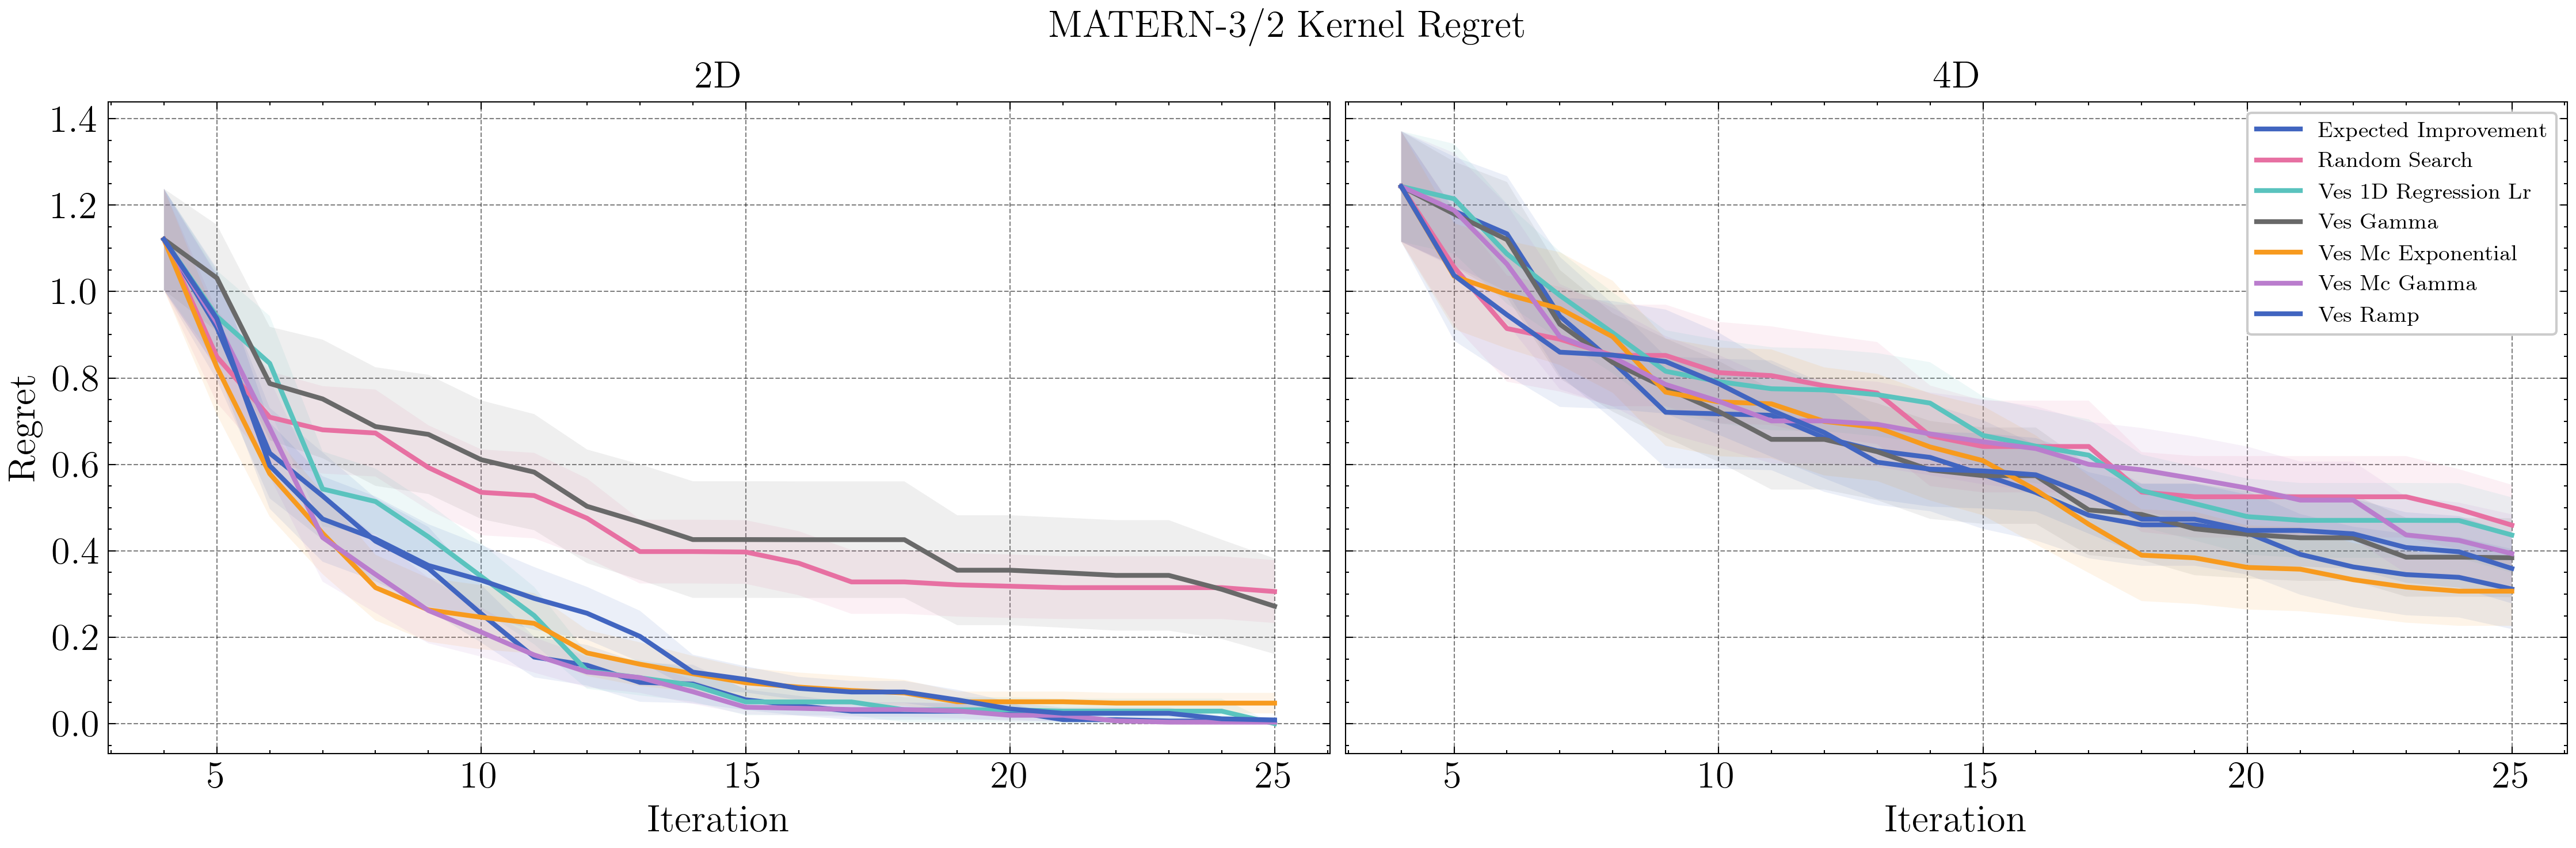

/Users/tomp/work/mes/paper_plots/benchmark-matern-5_2.png


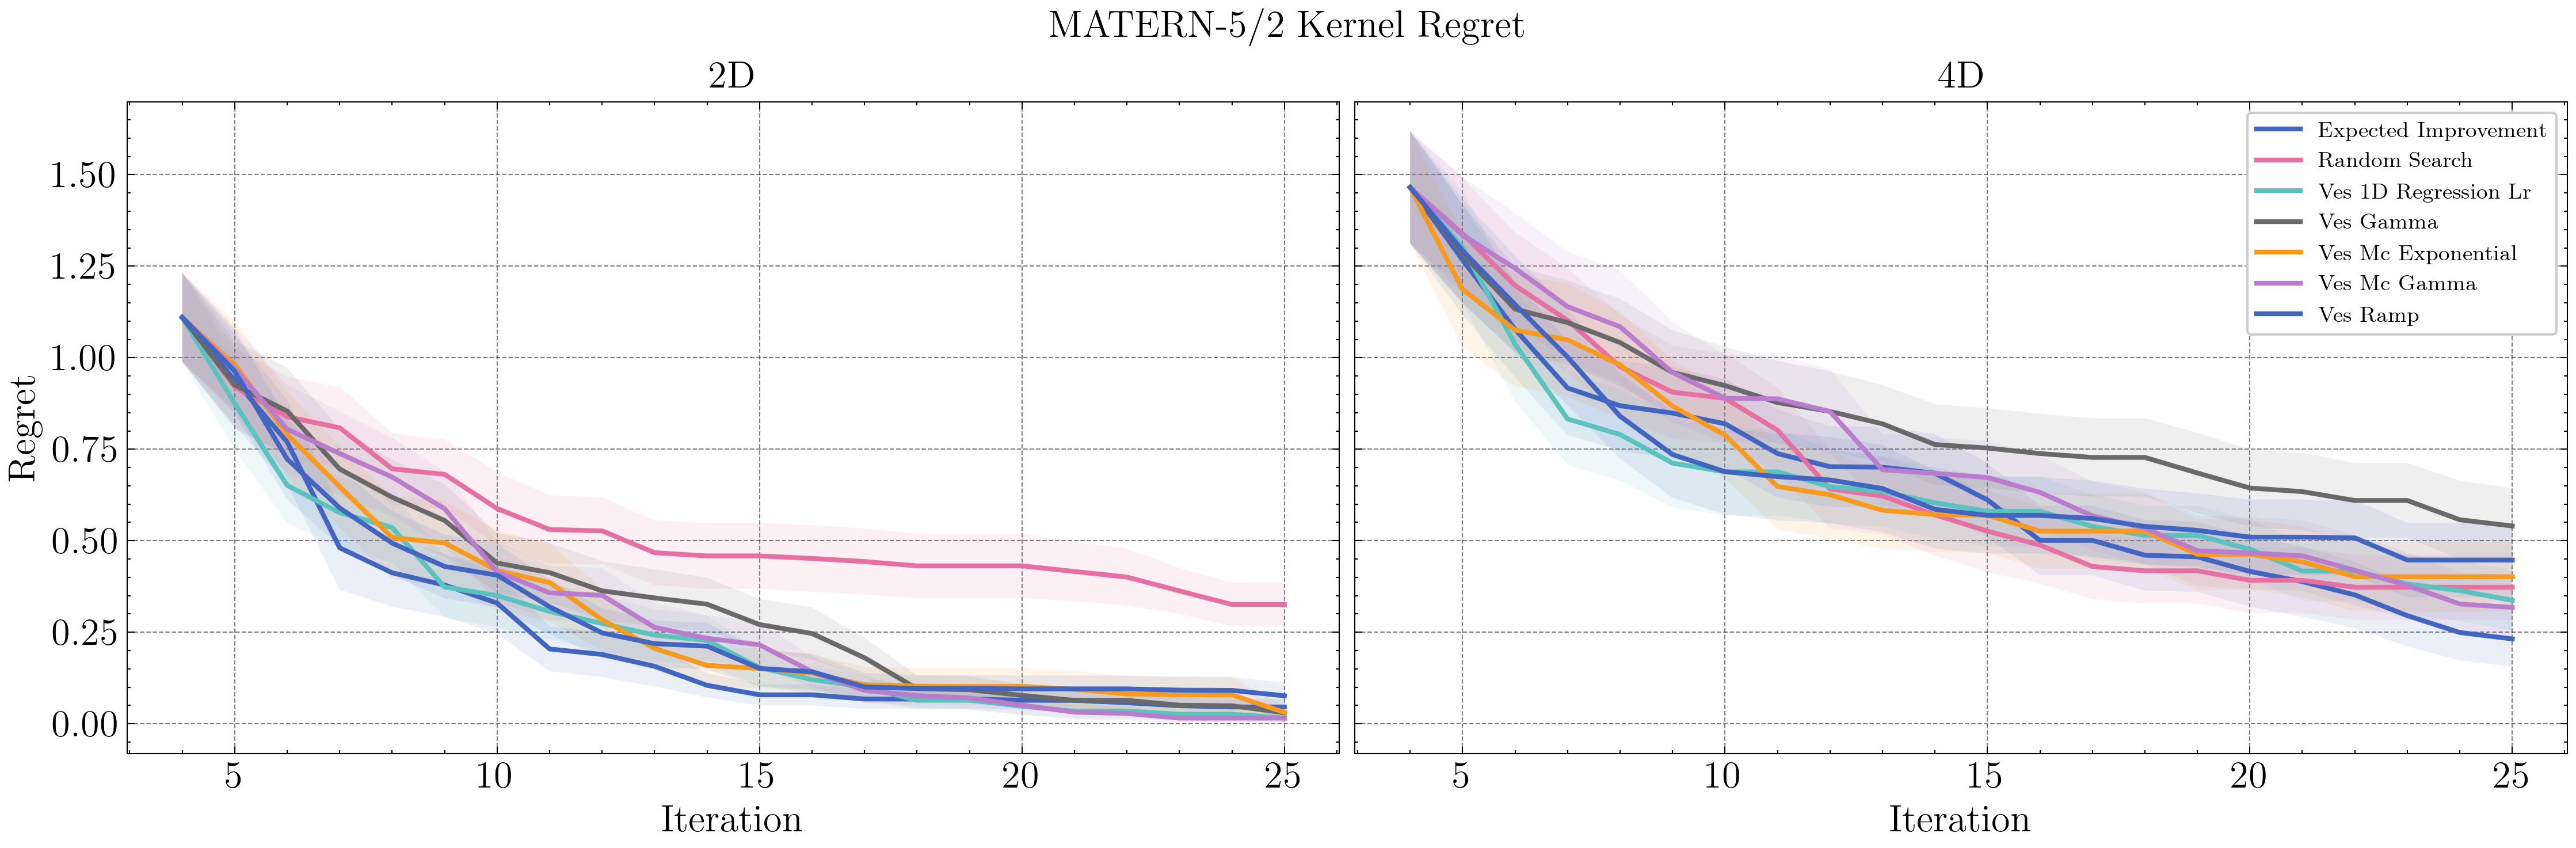

/Users/tomp/work/mes/paper_plots/benchmark-se.png


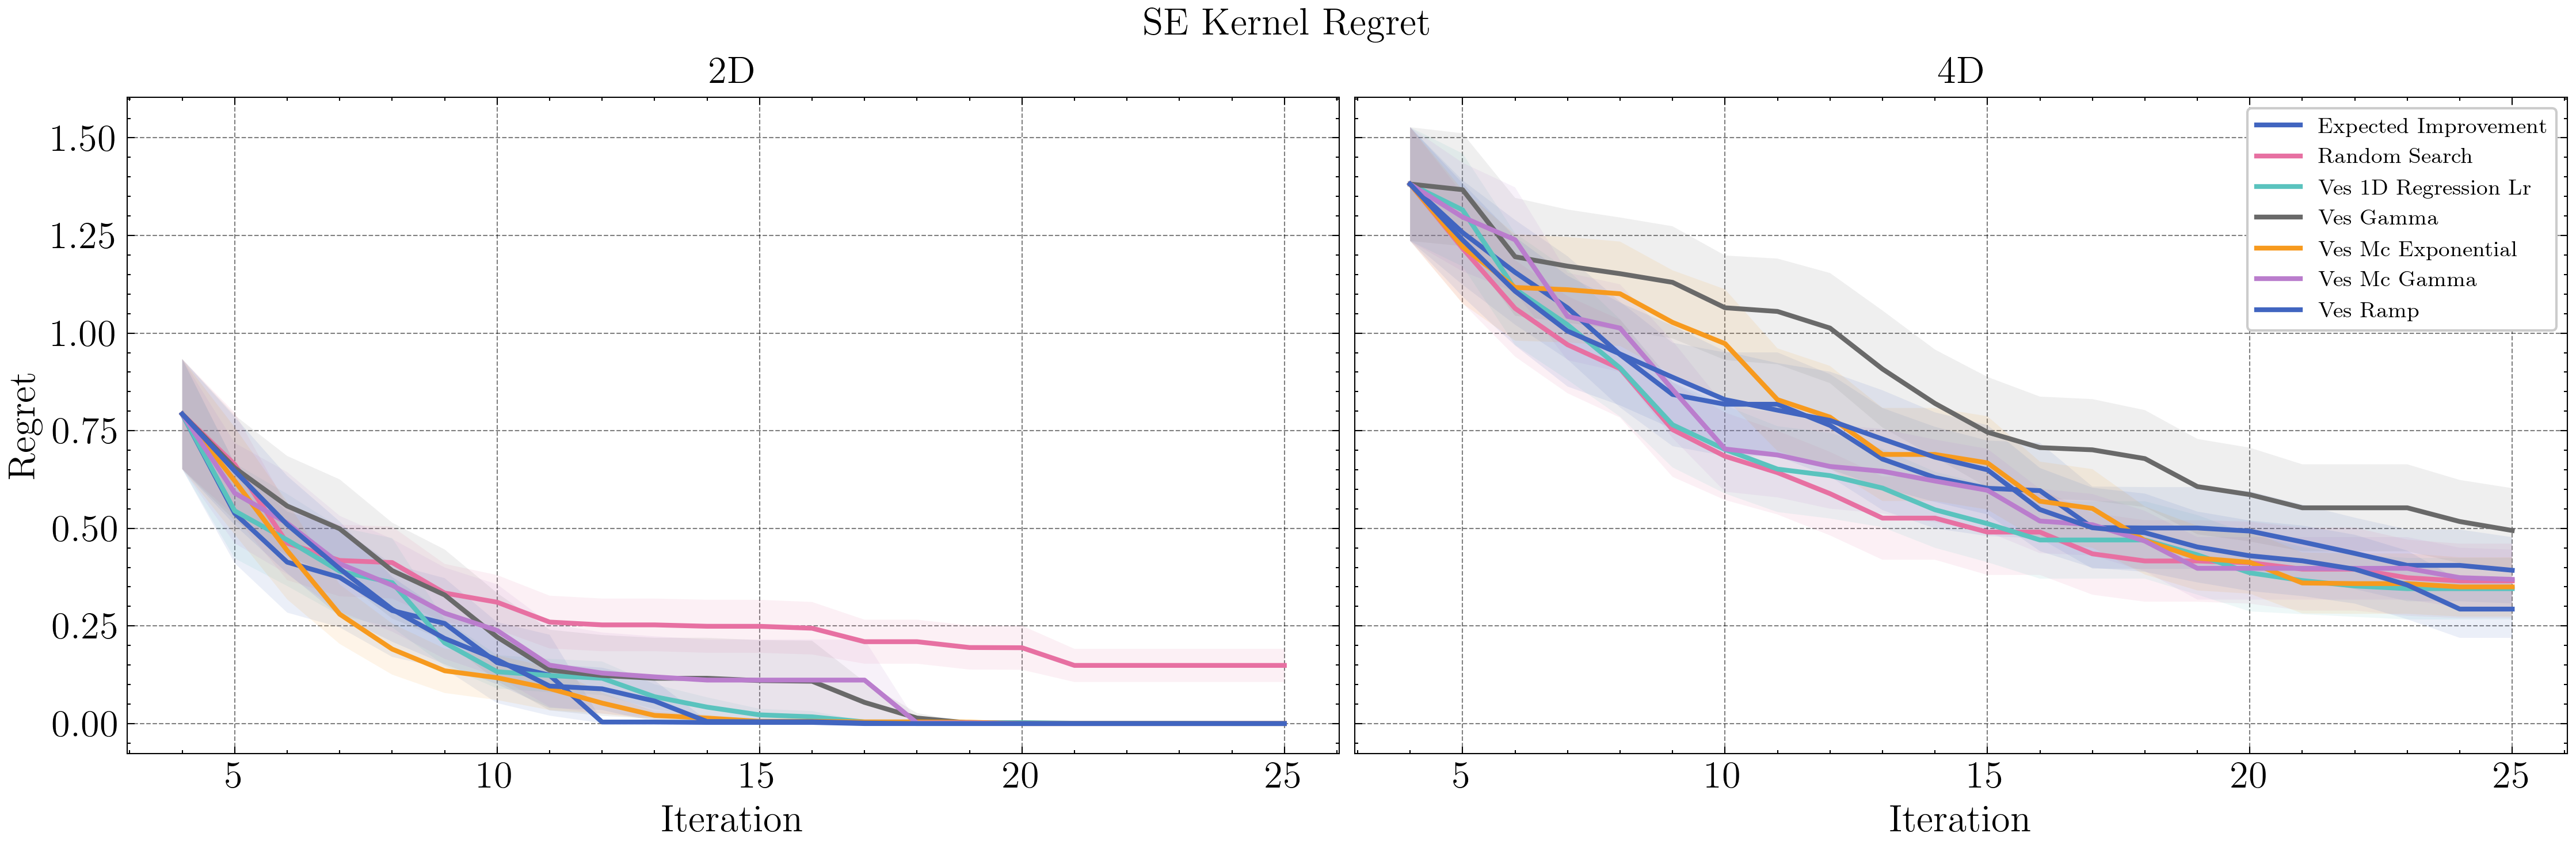

In [27]:
plt.style.use(['science', 'grid', 'retro'])
def _plot_single(ax, data, n_dim):
    """Plot regret data for a single dimension on the given axis"""
    for acq_func in data.index.get_level_values('acq_func').unique():
        acq_data = data.loc[acq_func]
        ax.plot(acq_data.index, acq_data['mean'],
                label=acq_func.replace('_', ' ').title(), linewidth=2)

        # Add confidence bands
        standard_error = acq_data['std'] / np.sqrt(acq_data['count'])
        ax.fill_between(acq_data.index,
                        acq_data['mean'] - standard_error,
                        acq_data['mean'] + standard_error,
                        alpha=0.1)

    ax.set_xlabel('Iteration')
    ax.set_title(f'{n_dim}D')
    # ax.grid(True, alpha=0.3) # use style instead

def plot_kernel(kernel_type, kernel_data):
    """Plot regret comparison for a specific kernel type with subplots for each dimension"""
    n_dims = kernel_data.index.get_level_values('n_dim').unique()

    fig, axes = plt.subplots(1, len(n_dims), figsize=(15, 5), sharey=True)
    if len(n_dims) == 1:
        axes = [axes]

    for i, n_dim in enumerate(n_dims):
        data = kernel_data.loc[n_dim]
        _plot_single(axes[i], data, n_dim)

        if i == 0:
            axes[i].set_ylabel('Regret')

    axes[-1].legend(loc='upper right', fontsize=9.2) # to put outside the plot: bbox_to_anchor=(1.05, 1), 
    fig.suptitle(f'{kernel_type.upper()} Kernel Regret', fontsize=16)
    plt.tight_layout()
    print(SAVE_DIR / f"benchmark-{kernel_type.replace('/', '_')}.png")
    fig.savefig(SAVE_DIR / f"benchmark-{kernel_type.replace('/', '_')}.png", dpi=300)
    plt.show()

for kernel_type in regret_df.index.get_level_values('kernel_type').unique():
    kernel_data = regret_df.loc[kernel_type]
    plot_kernel(kernel_type, kernel_data)